In this notebook the prepared data will be visualised.

Principles of data visualisation: 
1. Know the audience: Curse of expertise, informative labels.
2. One plot, one message.
3. Adapt figure to medium: Thicker lines, less information for smaller mediums.
4. Caption! 
5. Do not trust the defaults (especially in Matplotlib)
6. Use color effectively. Color maps: sequential vs diverging vs qualitative.

    *Diverging* = if there’s a meaningful middle point
    
    *Sequential* = for a more intuitive reading
7. Avoid chartjunk = unnecessary visual elements
8. Do not mislead audience
9. Chose message over beauty
10. Know and use the right tool: matplotlib, seaborn, geopandas, networkX.


0. Load the data

In [5]:
import os
import numpy as np
import pandas as pd

sessions = np.arange(25, 76)
data = []

# Load speeches
for session in sessions:
    directory = "./TXT/Session " + str(session) + " - " + str(1945 + session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0] == ".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945 + session, splt[0], f.read()])


df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_speech.head()

,Session,Year,ISO-alpha3 Code,Speech
0,25,1970,AUT,155.\t May I begin by expressing to Ambassado...
1,25,1970,MEX,"33.\t Mr. President, I take great pleasure in..."
2,25,1970,COG,122.\t I cannot begin my intervention without...
3,25,1970,DZA,1. The delegation of Algeria is very pleased ...
4,25,1970,LKA,"176.\t Mr. President, the delegation of Ceylon..."


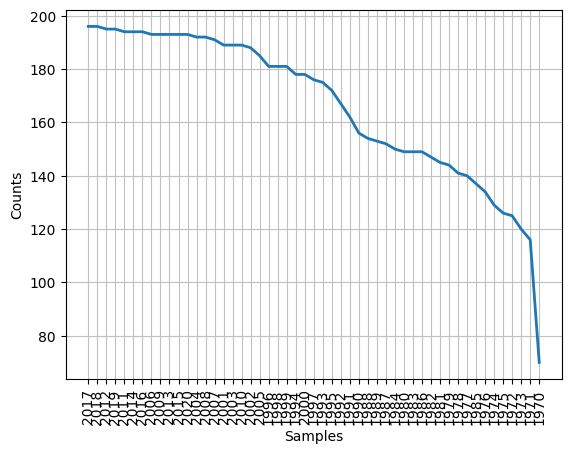

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [17]:
from nltk.probability import FreqDist

spread = FreqDist(df_speech['Year'].values) # just for testing purposes

FreqDist.plot(spread)

TypeError: float() argument must be a string or a real number, not 'FreqDist'

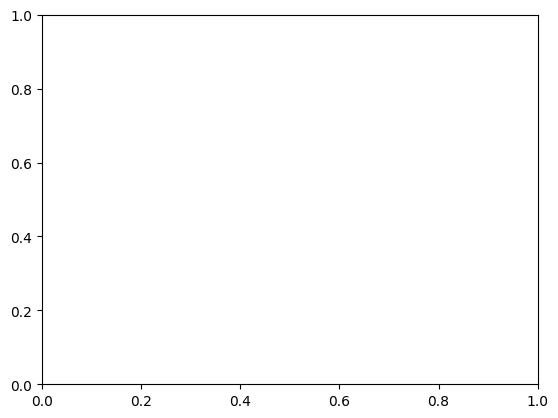

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
ax.plot(spread)

